#Kamal's Code:


In [0]:
from random import randint, choice, seed
from pprint import pprint
from itertools import permutations
from math import inf as oo # Infinity (∞) is larger than any number
from math import sqrt
from math import pow
from time      import time
import matplotlib.pyplot as plt
import copy
from google.colab import files

In [0]:
MAX_DISTANCE = 100

def random_symmetric_graph(n):
    ''' Symmetric adjacency matrix of size nxn '''
    dist_matrix = [[oo for _ in range(n)] for _ in range(n)]
    for i in range(n):
        for j in range(i+1,n):
            v = randint(1,MAX_DISTANCE)
            dist_matrix[i][j] = v
            dist_matrix[j][i] = v
    return dist_matrix

def random_euclidean_graph(n, points=None, max_d=MAX_DISTANCE):
    ''' Symmetric adjacency matrix of a Euclidean graph of size nxn '''
    dist_matrix = [[oo for _ in range(n)] for _ in range(n)]

    if not points: #so we can pass it our own points as well
        points = []
        for p in range(n):
            start = True
            while start or (x,y) in points:
                start=False
                x, y = randint(0, max_d), randint(0, max_d)
            points.append((x,y))
    for i in range(len(points)):
        p1 = points[i]
        for j in range(i+1,len(points)):
            p2 = points[j]
            distance = sqrt((p1[0]-p2[0])**2+(p1[1]-p2[1])**2)
            dist_matrix[i][j] = distance
            dist_matrix[j][i] = distance
    return points, dist_matrix

def show(G):
    ''' Show adjacency matrix. Useful for debugging. '''
    n = len(G)
    r = "     "
    for i in range(n):
        r += f'{i:4}'
    r += '\n    -'+'-'*(4*n)+'\n'
    for i in range(n):
        r += f'{i:2} | '
        for j in range(n):
            r += f'{G[i][j]:4}'
        r += '\n'
    r = r.replace('inf', '  ∞')
    print(r)

def cost(G, cycle):
    ''' Calculate the cost of the given cycle '''
    c = 0
    n = len(G)
    for i in range(n):
        a = cycle[i]
        b = cycle[(i+1)%n]
        c += G[a][b]
    return c
    
def greedy_nearest_neighbours(G, endpoints=None):
    H = copy.deepcopy(G) # We need the original G. We work on/modify H
    n = len(H)
    cities = list(range(n))
    cycle = [] # solution to be built
    city = 0 # Start city
    while len(cities)>0:
        # Find nearest neighbour
        city_neighbours = H[city]
        smallest_distance = min(city_neighbours)
        nearest_city = city_neighbours.index(smallest_distance)
        # Update 'cycle' and 'cities' and H then 'city'
        cycle.append(city)
        cities.remove(city)
        for i in range(n): # 'city' is not to be used again!
            H[city][i] = oo
            H[i][city] = oo
        city = nearest_city
    return cycle

def exhaustive_search(G, endpoints=None):
    n = len(G)    
    best_cost = oo # infinity
    best_cycle = []
    for cycle in permutations(range(1,n)): # permutations of [1,2,...,n-1]
        cycle=[0]+list(cycle)              # add the starting city: 0
        c = cost(G, cycle)
        if c < best_cost:
            best_cost = c
            best_cycle = cycle
    return best_cycle

# Utility Functions

In [0]:
def plotPoints(points, paths=True):
    if paths:
        for i in range(len(points)):
            for j in range(i, len(points)):
                plt.plot([points[i][0], points[j][0]], [points[i][1], points[j][1]])
    plt.show()

def plotSolution(solution, points):
    finalPoints = []
    for city in solution:
        for point in range(len(points)):
            if city==point:
                finalPoints.append(points[point])
    plt.scatter(*zip(*finalPoints))
    for i in range(len(points) -1):
        plt.plot([finalPoints[i][0], finalPoints[i+1][0]], [finalPoints[i][1], finalPoints[i+1][1]])
    plt.show()

def get_percentage_delta(graphList, allCosts1, allCosts2):
    costTotal1 = 0
    costTotal2 = 0 
    percentageDelta = []
    currentSize = 2 #always start at length 2

    for cost1, cost2, graph in zip(allCosts1, allCosts2, graphList):
        if len(graph) == currentSize: #so we average the same size graphs
            costTotal1 += cost1
            costTotal2 += cost2
        else:
            percentageDelta.append(costTotal1 / costTotal2 * 100)
            costTotal1 = 0
            costTotal2 = 0 
            currentSize = len(graph) #advance onto the next size

    if costTotal1 != 0 or costTotal2 != 0:
        percentageDelta.append(costTotal1 / costTotal2 * 100)

    return percentageDelta

def get_solutions_costs_times(tsp_function, graphList, maxTime=oo):
    allSolutions= []
    allCosts = []
    allTimes = []
    for graph in graphList: #looping over graphs
        start = time()
        pathAlgorithm = tsp_function(graph)
        totalTime = time() - start
        allSolutions.append(pathAlgorithm)
        allCosts.append(cost(graph, pathAlgorithm))
        allTimes.append(totalTime)
        if maxTime < totalTime:
            break

    return allSolutions, allCosts, allTimes

def euclidean(a, b):
    return ((a[1] - b[1])**2 + (a[0] - b[0])**2)**0.5

def get_aco_solutions_costs_times(pointList, graphList, maxTime=oo):
    allSolutions= []
    allCosts = []
    allTimes = []
    for points, graph in zip(pointsList, graphList):
        world = pants.World(points, euclidean)
        solver = pants.Solver()

        start = time()
        solution = solver.solve(world)
        totalTime = time()-start

        finalSolution = []
        for city in solution.tour:
            finalSolution.append(points.index(city))

        allSolutions.append(finalSolution)
        allTimes.append(totalTime)
        allCosts.append(cost(graph, finalSolution))
        print("%d : %f" % (len(points), totalTime))
        if maxTime < totalTime:
            break

    return allSolutions, allCosts, allTimes

def filter_costs_times(solutions, costs, times):
    filteredTimes = []
    filteredCosts = []
    timeTotal = 0
    costTotal = 0
    averageCounter = 0
    currentSize = len(solutions[0]) #always start at length 2
    for solution, cost, time in zip(solutions, costs, times):
        if len(solution) == currentSize: #so we average the same size graphs
            timeTotal += time
            costTotal += cost
            averageCounter += 1
        else:
            filteredTimes.append(timeTotal / averageCounter)
            filteredCosts.append(costTotal / averageCounter)
            timeTotal = 0
            costTotal = 0
            averageCounter = 0
            currentSize = len(solution) #advance onto the next size
    if averageCounter != 0:
        filteredTimes.append(timeTotal / averageCounter)
        filteredCosts.append(costTotal / averageCounter)
    return filteredCosts, filteredTimes

# GRASP Algorithm TSP, ref: https://github.com/dmishin/tsp-solver

In [0]:
!pip3 install tsp_solver2
from tsp_solver.greedy import solve_tsp

# ACO Algorithm TSP, ref: https://pypi.org/project/ACO-Pants/

In [0]:
!pip3 install ACO-Pants
import pants

# Creating Dataset 


In [0]:
max_size = 200

In [0]:
#Randomly Generated
graphList = []; pointsList = []
for i in range(2, max_size): # Create 200 graphs of sizes [2,max_size]
    for j in range(5): # do it 5 times each
        points, graph = random_euclidean_graph(i)
        graphList.append(graph)
        pointsList.append(points)

In [0]:
## From Existing Points in File
!rm input_points* 
points_file = files.upload()
pointsList=[]
for line in points_file["input_points.txt"].decode().split("\n")[:-1]:
    points= line[2:-2].split("), (")
    interList = []
    for point in points:
        point1=point.split(", ")[0]
        point2=point.split(", ")[1]
        interList.append((int(point1),int(point2)))
    pointsList.append(interList)
counter=0
graphList=[]
for points in pointsList:
        points, graph = random_euclidean_graph(None, pointsList[counter])
        graphList.append(graph)
        counter +=1

# Sending and receiving data fo PyConcorde Computation

In [14]:
# Exporting PointsList to file for Concorde Processing
file1= open("points_concorde.txt", "w")
for point in pointsList:
    outputStream = "["
    for element in point:
        outputStream += str(element) + ", "
    file1.write(outputStream[:-2] + "]\n")
files.download("points_concorde.txt")
print("Ensure line count of file is: ", len(pointsList))

Ensure line count of file is:  990


In [0]:
# Importing Solutions and Time from Concorde output files
!rm output*
concorde_file_solutions = files.upload() #Solutions only work from index 50 onwards
concorde_file_times = files.upload() #Only from 50 onwards

In [0]:
# Parsing files into standardised format
pyc_sols=[]
for line in concorde_file_solutions["output_solutions.txt"].decode().split("\n")[:-1]:
    tempSol=[]
    for element in line[1:-1].split(","):
        tempSol.append(int(element))
    pyc_sols.append(tempSol)

pyc_times=[]
for line in concorde_file_times["output_time.txt"].decode().split("\n")[:-1]:
    pyc_times.append(float(line))

pyc_costs=[]
for solution, graph in zip(pyc_sols, graphList):
    pyc_costs.append(cost(graph, solution))

# Computing GRASP, GreedyNN, Exhaustive, PyConcorde

In [0]:
sol4, cost4, time4 = get_aco_solutions_costs_times(pointsList, graphList, maxTime=8)
sol1, cost1, time1 = get_solutions_costs_times(solve_tsp, graphList)
sol2, cost2, time2 = get_solutions_costs_times(greedy_nearest_neighbours, graphList)
sol3, cost3, time3 = get_solutions_costs_times(exhaustive_search, graphList, maxTime=8)

In [0]:
filter_cost_tsp, filter_time_tsp = filter_costs_times(sol1, cost1, time1)
filter_cost_gnn, filter_time_gnn = filter_costs_times(sol2, cost2, time2)
filter_cost_pyc, filter_time_pyc = filter_costs_times(pyc_sols, pyc_costs, pyc_times)
filter_cost_exh, filter_time_exh = filter_costs_times(sol3, cost3, time3)
filter_cost_aco, filter_time_aco = filter_costs_times(sol4, cost4, time4)

# Showing different solution approaches at 200 cities 

All possible paths.


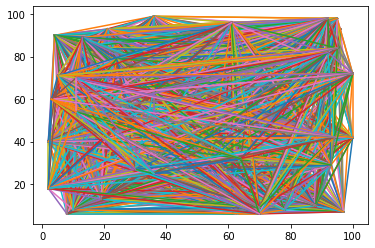

Cost of GreedyNN solution:  817


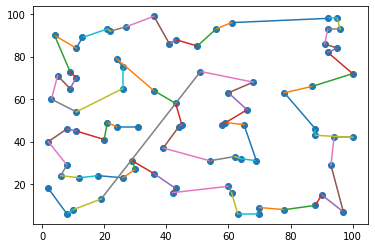

Cost of GRASP solution:  853


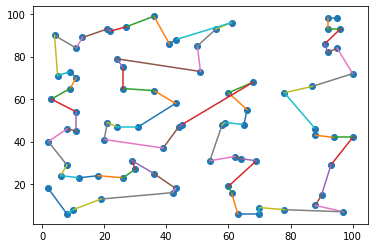

Cost of ACO solution:  1033


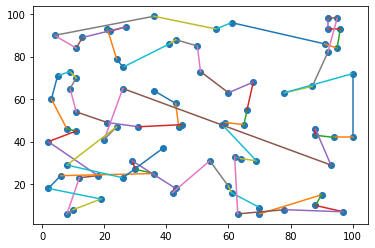

Cost of PyConcorde solution:  708


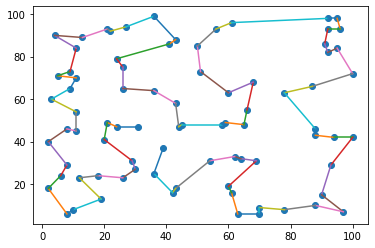

In [27]:
n = 400 #Position you want to see solution at

print("All possible paths.")
plotPoints(pointsList[n])
print("Cost of GreedyNN solution: ", round(cost2[n]))
plotSolution(sol2[n], pointsList[n])
print("Cost of GRASP solution: ", round(cost1[n]))
plotSolution(sol1[n], pointsList[n])
print("Cost of ACO solution: ", round(cost4[n]))
plotSolution(sol4[n], pointsList[n])
print("Cost of PyConcorde solution: ", round(pyc_costs[n]))
plotSolution(pyc_sols[n], pointsList[n])

# Cost (20c): GreedyNN vs GRASP  vs PyConcorde vs Exhaustive vs ACO

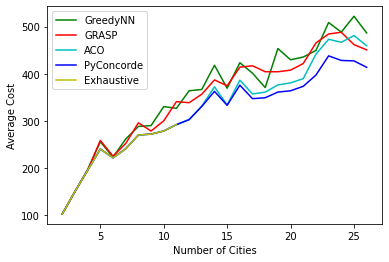

In [21]:
plt.plot(range(2, 27) , filter_cost_gnn[:25], 'g', label="GreedyNN")
plt.plot(range(2, 27) , filter_cost_tsp[:25], 'r', label="GRASP")
plt.plot(range(2, 27) , filter_cost_aco[:25], 'c', label="ACO")
plt.plot(range(2, 27) , filter_cost_pyc[:25], 'b', label="PyConcorde")
plt.plot(range(2, 12) , filter_cost_exh, 'y', label="Exhaustive")

plt.xlabel("Number of Cities")
plt.ylabel("Average Cost")
plt.legend()
plt.show()

## Time (20c): GreedyNN vs TSP-Solver vs PyConcorde vs Exhaustive

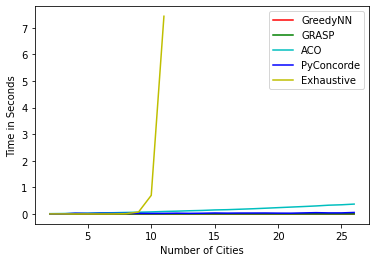

In [22]:
plt.plot(range(2, 27) , filter_time_gnn[:25], 'r', label="GreedyNN")
plt.plot(range(2, 27) , filter_time_tsp[:25], 'g', label="GRASP")
plt.plot(range(2, 27) , filter_time_aco[:25], 'c', label="ACO")
plt.plot(range(2, 27) , filter_time_pyc[:25], 'b', label="PyConcorde")
plt.plot(range(2, 12) , filter_time_exh, 'y', label="Exhaustive")

plt.xlabel("Number of Cities")
plt.ylabel("Time in Seconds")
plt.legend()
plt.show()


# Quality (200c): GreedyNN vs TSP-Solver  vs PyConcorde


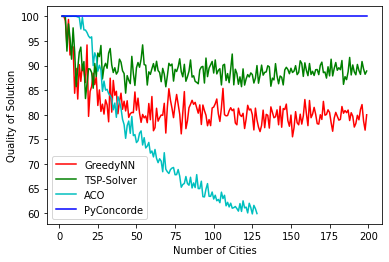

In [23]:
tsp_vs_pyc = get_percentage_delta(graphList, pyc_costs, cost1)
gnn_vs_pyc = get_percentage_delta(graphList, pyc_costs, cost2)
aco_vs_pyc = get_percentage_delta(graphList, pyc_costs[:len(cost4)], cost4)

plt.plot(range(2, max_size) ,       gnn_vs_pyc,  'r', label="GreedyNN")
plt.plot(range(2, max_size) ,       tsp_vs_pyc,  'g', label="TSP-Solver")
plt.plot(range(2, len(aco_vs_pyc)+2), aco_vs_pyc,  "c", label="ACO")
plt.plot(range(2, max_size), [100]*(max_size-2), "b", label="PyConcorde")

plt.xlabel("Number of Cities")
plt.ylabel("Quality of Solution")
plt.legend()
plt.show()

## Cost (200c):  GreedyNN vs TSP-Solver vs PyConcorde

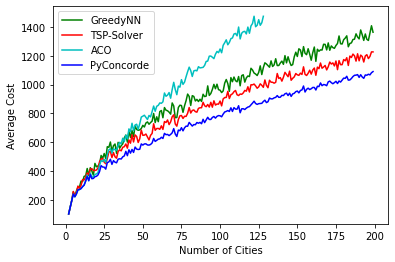

In [25]:
plt.plot(range(2, max_size) , filter_cost_gnn, 'g', label="GreedyNN")
plt.plot(range(2, max_size) , filter_cost_tsp, 'r', label="TSP-Solver")
plt.plot(range(2, len(aco_vs_pyc)+2) , filter_cost_aco, 'c', label="ACO")
plt.plot(range(2, max_size) , filter_cost_pyc, 'b', label="PyConcorde")

plt.xlabel("Number of Cities")
plt.ylabel("Average Cost")
plt.legend()
plt.show()

# Time (200c): GreedyNN vs TSP-Solver vs PyConcorde


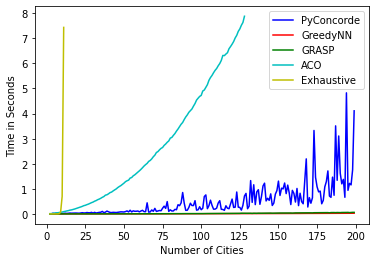

In [26]:
plt.plot(range(2, max_size) , filter_time_pyc, 'b', label="PyConcorde")
plt.plot(range(2, max_size) , filter_time_gnn, 'r', label="GreedyNN")
plt.plot(range(2, max_size) , filter_time_tsp, 'g', label="GRASP")
plt.plot(range(2, len(aco_vs_pyc)+2) , filter_time_aco, 'c', label="ACO")
plt.plot(range(2, 12) , filter_time_exh, 'y', label="Exhaustive")

plt.xlabel("Number of Cities")
plt.ylabel("Time in Seconds")
plt.legend()
plt.show()

# Analysis based on city density: PyConcorde vs GRASP
### 10 graph average--> sizes [10, 15, 20...395, 400] on 20x20 grid

In [0]:
graphList = []; pointsList = []
for i in range(10, 401)[::5]:
    for j in range(10): # do it 10 times each
        points, graph = random_euclidean_graph(i, max_d=19)
        graphList.append(graph)
        pointsList.append(points)

790
		50 cities, density: 0.125


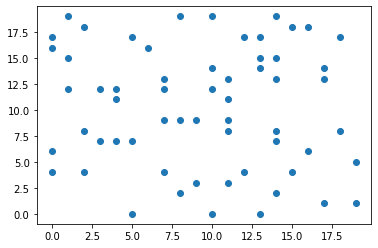

		200 cities, density: 0.5


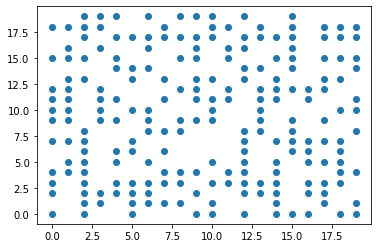

		400 cities, density: 1


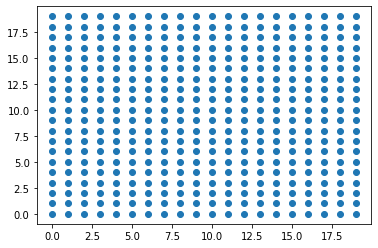

In [0]:
print("\t\t50 cities, density: 0.125")
plotPoints(pointsList[ 50*2], paths=False)
print("\t\t200 cities, density: 0.5")
plotPoints(pointsList[200*2], paths=False)
print("\t\t400 cities, density: 1")
plotPoints(pointsList[-1], paths=False)

## Solving in both GNN and PyConcorde

In [0]:
# Exporting PointsList to file for Concorde Processing
file1= open("density_points.txt", "w")
for point in pointsList:
    outputStream = "["
    for element in point:
        outputStream += str(element) + ", "
    file1.write(outputStream[:-2] + "]\n")
files.download("density_points.txt")

In [0]:
# Importing Solutions and Time from Concorde output files
!rm density*.txt
concorde_file_solutions = files.upload() #Solutions only work from index 50 onwards
concorde_file_times = files.upload() #Only from 50 onwards

# Parsing files into standardised format
pyc_sols=[]
for line in concorde_file_solutions["density_output_solutions.txt"].decode().split("\n")[:-1]:
    tempSol=[]
    for element in line[1:-1].split(","):
        tempSol.append(int(element))
    pyc_sols.append(tempSol)

pyc_times=[]
for line in concorde_file_times["density_output_time.txt"].decode().split("\n")[:-1]:
    pyc_times.append(float(line))

pyc_costs=[]
for solution, graph in zip(pyc_sols, graphList):
    pyc_costs.append(cost(graph, solution))

filter_cost_pyc, filter_time_pyc = filter_costs_times(pyc_sols, pyc_costs, pyc_times)

In [0]:
sol1, cost1, time1 = get_solutions_costs_times(solve_tsp, graphList)
filter_cost_tsp, filter_time_tsp = filter_costs_times(sol1, cost1, time1)

## Example of solution where TSP-Solver outperforms PyConcorde 
## Density=0.72, Cities=288/400

All cities.


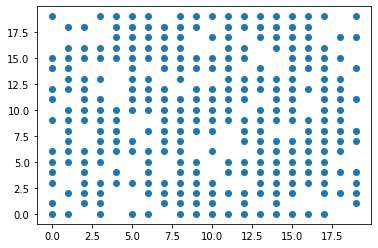

Cost of TSP-Solver solution:  342


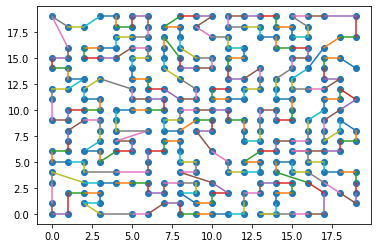

Cost of PyConcorde solution:  352


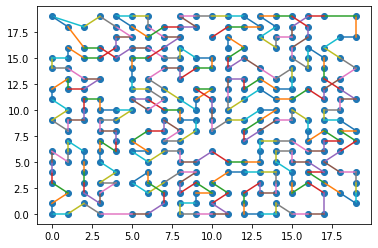

In [0]:
n = 288*2

print("All cities.")
plotPoints(pointsList[n], paths=False)
print("Cost of TSP-Solver solution: ", round(cost1[n]))
plotSolution(sol1[n], pointsList[n])
print("Cost of PyConcorde solution: ", round(pyc_costs[n]))
plotSolution(pyc_sols[n], pointsList[n])

## Cost: TSP-Solver vs PyConcorde

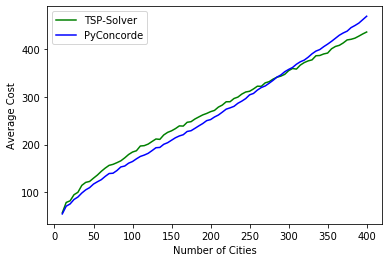

In [0]:
plt.plot(range(10,401)[::5], filter_cost_tsp, 'g', label="TSP-Solver")
plt.plot(range(10,401)[::5], filter_cost_pyc, 'b', label="PyConcorde")

plt.xlabel("Number of Cities")
plt.ylabel("Average Cost")
plt.legend()
plt.show()

## Time: TSP-Solver vs PyConcorde

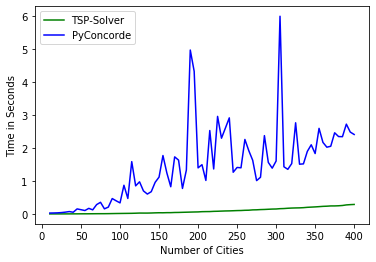

In [0]:
plt.plot(range(10,401)[::5], filter_time_tsp, 'g', label="TSP-Solver")
plt.plot(range(10,401)[::5], filter_time_pyc, 'b', label="PyConcorde")

plt.xlabel("Number of Cities")
plt.ylabel("Time in Seconds")
plt.legend()
plt.show()